## Project 5: mmRAPID Simulation

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from copy import deepcopy

In [2]:
np.random.seed(42)

### Functions

#### snr(v_out, v_in)

In [3]:
##### Compute SNR
def snr(v_out, v_in):
  '''
  Returns SNR in dB
  '''
  v_out_np = np.array(v_out).reshape(-1,1)
  v_in_np = np.array(v_in).reshape(-1,1)
  return 10*np.log10(np.mean(np.abs(v_out_np**2))/np.mean(np.abs(v_in_np**2)))

#### awgn(x, snr, is_complex=True, dB_mode=True)

In [4]:
##### Generate Gaussian noise using SNR
def awgn(x, snr, is_complex=True, dB_mode=True):
  '''
  If dB_mode is True, snr = 10*log10(linear_snr)
  Otherwise, snr = linear_snr
  '''
  x_arr = np.array(x)
  linear_snr = 10.0 ** (snr/10.0)
  if (dB_mode==False):
    linear_snr = snr

  signal_power = np.mean(np.abs(x_arr**2))

  if (is_complex):
    noise_vec = np.sqrt(signal_power/linear_snr) * 1/np.sqrt(2) * np.array(np.random.randn(len(np.atleast_1d(x_arr))) + 1j*np.random.randn(len(np.atleast_1d(x_arr))))
    return noise_vec
  else:
    noise_vec = np.sqrt(signal_power/linear_snr) * np.random.randn(len(np.atleast_1d(x_arr)))
    return noise_vec


#### double_sample_with_spacing(x_vec, spacing=10)

In [5]:
##### Sample unique points from an array without replacement, given a certain spacing between elements
def double_sample_with_spacing(x_vec, spacing=10, return_inds=False):
  '''
  ##### ========= Inputs ========= #####
  x_vec: Vector whose elements are unique

  ##### ========= Returns ========= #####
  Returns x_vec if returns_inds==False (default)
  Returns the tuple (ind_1, ind_2, x_vec) otherwise
  '''
  sample_num = 2 # number of samples
  if (np.max(x_vec) - np.min(x_vec) >= spacing):
    sample_pt_1 = np.random.choice(x_vec)
    inds_select = np.where(np.abs(x_vec-sample_pt_1) >= spacing/2)
    sample_pt_2 = np.random.choice(x_vec[inds_select])

    sample_arr_np = np.array([sample_pt_1, sample_pt_2])

    if (return_inds==True):
      ind_1 = np.where(x_vec==sample_pt_1)
      ind_2 = np.where(x_vec==sample_pt_2)
      return (ind_1, ind_2, sample_arr_np)
    else:
      return sample_arr_np
  else:
    print('Array size or spacing size is incompatible.')

#### generate_alpha_2(alpha_1, secondary_path_gain_dB=-15)

In [6]:
def generate_alpha_2(alpha_1, secondary_path_gain_dB=-15):
  '''
  secondary_path_gain_dB = 10*log10(np.mean(alpha_2**2)/np.mean(alpha_1**2))
  '''
  alpha_2 = np.sqrt((1) * (np.mean(alpha_1**2) * (10**(secondary_path_gain_dB/10))))
  return alpha_2

#### generate_array_response(N_array_elements, select_angle, d_lambda_ratio=0.5, angle_mode='radians')

In [7]:
##### Generate array response
def generate_array_response(N_array_elements, select_angle, d_lambda_ratio=0.5, angle_mode='radians'):
  '''
  N_array_elements: N_R or N_T
  select_angle: AoA or AoD
  d_lambda_ratio: antenna spacing divided by wavelength

  Returns: A vector representing the array response (unit power).
  '''
  if (angle_mode=='degrees'):
    a = np.matrix(np.exp(1j*2*np.pi*np.arange(0,N_array_elements)*d_lambda_ratio*np.sin(select_angle*np.pi/180)).reshape(N_array_elements,1))
    return(a.reshape(-1,1))
  elif (angle_mode=='radians'):
    a = np.matrix(np.exp(1j*2*np.pi*np.arange(0,N_array_elements)*d_lambda_ratio*np.sin(select_angle)).reshape(N_array_elements,1))
    return(a.reshape(-1,1))
  else:
    print('Specify angle mode.')

#### generate_channel_model(a_R_phi_1, a_R_phi_2, alpha_1, alpha_2, L=2)

In [8]:
def generate_channel_model(a_R_phi_1, a_R_phi_2, alpha_1, alpha_2, L=2):
  '''
  ##### ===== UNUSED ===== #####
  a_R_phi_1:              Array response at receiver (Rx) / mobile station (MS) for path 1 (L=1), evaluated at phi_1
  a_R_phi_2:              Array response at receiver (Rx) / mobile station (MS) for path 2 (L=2), evaluated at phi_1
  alpha_1:                Post-Tx-beam channel gain for path 1 (L=1)
  alpha_2:                Post-Tx-beam channel gain for path 2 (L=2)
  L:                      Number of paths (Set to either L=1 or L=2)
  '''
  h1 = alpha_1*a_R_phi_1
  h2 = alpha_2*a_R_phi_2
  h = h1 + h2
  if (L==1):
    return(h1)
  elif (L==2):
    return(h)
  else:
    print('Set L=1 or L=2')


#### generate_gain_error_vec(N_elements)

In [9]:
def generate_gain_error_vec(N_elements):
  return 0.25*np.sin(0.4*np.pi*np.arange(1,N_elements+1)) # start at index 0 or index 1?

#### generate_phase_error_vec(N_elements)

In [10]:
def generate_phase_error_vec(N_elements):
  return 15*np.sin(0.3*np.pi*np.arange(1,N_elements+1)) # start at index 0 or index 1?

#### create_directional_codeword(sel_angle, N_elements, angle_mode='radians')

In [11]:
def create_directional_codeword(sel_angle, N_elements, angle_mode='radians', d_lambda_ratio=0.5):
  sel_angle_rad = sel_angle
  if (angle_mode=='degrees'):
    sel_angle_rad = sel_angle * np.pi/180
  a_R = generate_array_response(N_elements, sel_angle_rad, d_lambda_ratio=d_lambda_ratio)
  wd_k = 1/np.sqrt(N_elements) * a_R
  return wd_k

#### create_compressive_codeword(N_elements, sel_angle_dist=np.array([0, np.pi/2, np.pi, 3/2*np.pi]))


In [12]:
def create_compressive_codeword(N_elements, sel_angle_dist=np.array([0, np.pi/2, np.pi, 3/2*np.pi])):
  sel_angles_rad = np.random.choice(sel_angle_dist, size=N_elements)
  ws_m = 1/np.sqrt(N_elements) * np.exp(1j*sel_angles_rad)
  return ws_m


#### generate_channel_matrix(N_R, n_instances, alpha_1, true_AoA_dist, spacing_rad, angle_mode='radians', secondary_path_gain_dB=-15, L=2, d_lambda_ratio=0.5):


In [13]:
def generate_channel_matrix(N_R, n_instances, alpha_1, true_AoA_dist, spacing_rad, angle_mode='radians', secondary_path_gain_dB=-15, L=2, d_lambda_ratio=0.5, random_seed_on=True, random_seed_num=42):
  '''
  ##### ========= Inputs ========= #####
  N_R: Number of antenna array elements
  n_instances: Number of channel instances to generate
  alpha_1: The gain associated with the true AoA. If L=2,
  true_AoA_dist: K-element array of AoA angles from which a true AoA and a second AoA will be randomly sampled
  spacing_rad: Minimum absolute difference beteen the two randomly sampled angle (default is in radians)
  angle_mode: Default is in radians, change to 'degrees' if the parameter spacing_rad is in degrees
  secondary_path_gain_dB: Gain in dB of the second path, relative to alpha_1. Utilized for the computation of alpha_2
  L: Number of channel paths, set to either L=1 or L=2 (default is L=2)
  d_lambda_ratio: Spacing for antenna array (default is 0.5, for half-wavelength spacing)
  random_seed: Set to true generate consistent channel models
  random_seed_num: Random seed number (default is 42)

  ##### ========= Returns ========= #####
  Returns the tuple (true_AoA_inds_np, secondary_AoA_inds_np, H)

  true_AoA_inds_np: The indices (labels) associated with each true AoA sampled from true_AoA_dist (size = n_instances)
  secondary_AoA_inds_np: The indices associated with each secondary path AoA sampled from true_AoA_dist (size = n_instances)
  H: a matrix of channel vectors with dimensions N_R x n_instances
  '''
  if (random_seed_on == True):
    np.random.seed(random_seed_num)

  select_spacing = spacing_rad
  if (angle_mode=='degrees'):
    select_spacing = spacing_rad*180/np.pi

  true_AoA_inds = list()
  secondary_AoA_inds = list()
  H = list()
  for ind in np.arange(n_instances):
    # Randomly generate angles with spacing
    phi_1, phi_2, (true_ind, secondary_ind) = double_sample_with_spacing(true_AoA_dist, spacing=select_spacing, return_inds=True)

    # Generate array responses for l=1 and l=2
    a_R_phi_1 = generate_array_response(N_R, phi_1, d_lambda_ratio, angle_mode='radians')
    a_R_phi_2 = generate_array_response(N_R, phi_2, d_lambda_ratio, angle_mode='radians')

    # Compute alpha_2 based on alpha_1 and secondary_path_gain_dB
    alpha_2 = generate_alpha_2(alpha_1, secondary_path_gain_dB)

    # Combine array responses and associated gains to make a channel model instance h
    h1 = alpha_1/np.sqrt(N_R)*a_R_phi_1
    h2 = alpha_2/np.sqrt(N_R)*a_R_phi_2
    h = h1 + h2

    # Add array response instance to H
    if (L==2):
      H.append(h)
    elif (L==1):
      H.append(h1)
    else:
      print('L must be L=1 or L=2.')
      break

    # Save indices for path l=1 and path l=2
    true_AoA_inds.append(phi_1)
    secondary_AoA_inds.append(phi_2)

  H_np = np.concatenate(H,axis=1).reshape(N_R, n_instances) # A matrix of channel vectors with dimensions N_R x n_instances
  true_AoA_inds_np = np.array(true_AoA_inds).reshape(len(true_AoA_inds))
  secondary_AoA_inds_np = np.array(secondary_AoA_inds).reshape(len(true_AoA_inds))

  return (true_AoA_inds_np, secondary_AoA_inds_np, H_np)


#### generate_awgn_matrix(H,snr)

In [14]:
def generate_awgn_matrix(H,snr_dB):
  '''
  ##### ========= Inputs ========= #####
  H: A channel matrix (a 2D numpy array) with dimensions N_R x n_instances
  snr_dB: The desired signal to noise ratio, in dB

  ##### ========= Returns ========= #####
  noise_mat_np: A matrix of awgn vectors correponding to the desired snr

  '''
  noise_mat = list()
  N_R, n_instances = H.shape
  for col in np.arange(n_instances):
    noise_vec = awgn(H[:,col], snr_dB, is_complex=True, dB_mode=True)
    noise_mat.append(noise_vec)

  noise_mat_np = np.array(noise_mat).reshape(N_R, n_instances)
  return noise_mat_np


### Generate System Model

#### Constants

In [15]:
N_T = 1 ##### Number of transmitters
N_R = 32 ##### Number of receiver antennas
d_lambda_ratio = 0.5
thetas = 20 # radians, remains fixed for the entire project
phis = 30 # radians

#### Array responses

In [16]:
a_T = generate_array_response(N_T, thetas, d_lambda_ratio, angle_mode='degrees')
a_R = generate_array_response(N_R, phis, d_lambda_ratio, angle_mode='degrees')

In [17]:
print(a_T.shape)
print(a_R.shape)

(1, 1)
(32, 1)


In [18]:
post_Tx_beam_channel_gain = 10 # Arbitrary???
v = a_T / np.sqrt(N_R)
alpha_1 = post_Tx_beam_channel_gain * a_T.H @ v ##### alpha_1 is just a constant

#### Set post-Tx-beam channel gains for L=1 and L=2

In [19]:
secondary_path_gain_dB = -15 # in dB, adjustable parameter
alpha_1 = 10
alpha_2 = generate_alpha_2(alpha_1)
snr(alpha_2,alpha_1)

-15.0

In [20]:
double_sample_with_spacing(np.arange(11))

array([6, 1])

### Generate Channel Model

#### Notation

$\mathbf{y} = |\mathbf{W}^{H}\mathbf{B}(\mathbf{h}s+\mathbf{n})|^{2}$
<br>
$\mathbf{y}$: RSS Measurement Vector, where $\mathbf{y} \in \mathbb{R}^{M}$. (The vector $\mathbf{y}$ is an "instance" with associated a given AoA (i.e., a given $\mathbf{h}$).
<br>
$\mathbf{W}$: Codebook of stacked PN beamformers, where $\mathbf{W} \in \mathbb{C}^{N_{R} \times M}$. Note that $\mathbf{W}:=\mathbf{W_s}$.
<br>
$s$: The "1" symbol
<br>
$\mathbf{B}$: Impairments ($\mathbf{B}=diag(\mathbf{b}$), where $\mathbf{b}_{i} = (1+g_{err}(i))e^{jp_{err}(i)})$
<br>
$\mathbf{h}$: Channels (2 AWVs, contains the "true" AoA, plus second AoA associated with undesired beam.)
<br>
$\mathbf{n}$: AWGN

#### Define h

In [21]:
h = generate_channel_model(a_R, a_T, alpha_1, alpha_2)

#### AoA vectors

In [22]:
#### Generate vector of AoAs
K = 64
AoA_vec_K = np.linspace(-np.pi/3, np.pi/3, K) #### These correspond to my labels
AoA_vec_M = np.array([0, np.pi/2, np.pi, 3/2*np.pi]) #### Pseudorandom sampling of these angles are used to create my features

#### SNR dB range

In [23]:
##### Generate array of SNRs (in dB)
snr_range_dB = np.arange(0,31,5) # 0:5:30 dB

### Codebook Design

#### Directional Codebook $\mathbf{W}_D$ (|$\mathbf{W}_D$| = K codewords, K = 64)

In [24]:
# W_D: A matrix with dimensions N_R x K
# Use AoA_vec_K (radians) to define each column of W_D
K = 64
W_D = list()
for col in np.arange(K):
  W_D.append(create_directional_codeword(sel_angle=AoA_vec_K[col], N_elements=N_R))

W_D = np.matrix(np.array(W_D).reshape(N_R,K))
W_D.shape

(32, 64)

#### Compressive Codebook $\mathbf{W}_S$ (|$\mathbf{W}_S$| = M codewords, M = 4, 8, 12)

In [25]:
# W_S: A matrix with dimensions N_R x K
# Use AoA_vec_M (radians) to define each column of W_D
# Select 4, 8, or 12 columns, depending on how many measurements we want to use
M = 12
W_S = list()
for col in np.arange(M):
  sel_random_phase = np.random.choice(AoA_vec_M)
  W_S.append(create_compressive_codeword(N_elements=N_R, sel_angle_dist=AoA_vec_M))

W_S = np.matrix(np.array(W_S).reshape(N_R,M))
W_S.shape

(32, 12)

### Array Impairments

#### Generate gain error g and phase error p

In [26]:
g_err_vec = generate_gain_error_vec(N_R) # Gain error vector
p_err_vec = generate_phase_error_vec(N_R) # Phase error vector

#### Generate matrix of impairments $\mathbf{B}$

In [27]:
##### Generate matrix of impairments
b = (1 + g_err_vec) * np.exp(1j*p_err_vec)
B = np.diag(b)
B_gain = np.diag(1+g_err_vec)
B_angle = np.diag(np.exp(1j*p_err_vec))

### Angle Estimation Algorithm

In [28]:
import torch
import torch.nn as nn

#### Create NN Model (PyTorch)

In [29]:
class mmRAPID_MLP(nn.Module):
  def __init__(self, M=12, K=64, hidden_layers=[64, 128]):
    super().__init__()

    self.hidden_layers = hidden_layers
    self.input_dim = M
    self.output_dim = K
    #self.output_dim = K
    self.relu = nn.ReLU()

    self.linear_bn1 = nn.BatchNorm1d(self.input_dim)
    self.linear1 = nn.Linear(self.input_dim, self.hidden_layers[0])
    self.drop1 = nn.Dropout(0.5)

    self.linear_bn2 = nn.BatchNorm1d(self.hidden_layers[0])
    self.linear2 = nn.Linear(self.hidden_layers[0], self.hidden_layers[1])
    self.drop2 = nn.Dropout(0.5)

    self.linear3 = nn.Linear(self.hidden_layers[1], self.output_dim)

  def forward(self, x):
    h = x

    h = self.linear_bn1(h)
    h = self.relu(h)
    #h = self.drop1(h) # experimental
    h = self.linear1(h)

    h = self.linear_bn2(h)
    h = self.relu(h)
    #h = self.drop2(h) # experimental
    h = self.linear2(h)

    h = self.linear3(h)

    return(h)

### Dataset Generation

#### class ConstructDataset

In [30]:
class ConstructDataset(torch.utils.data.Dataset):
  def __init__(self, X, Y):
    device_id = 0 if torch.cuda.is_available() else 'cpu'
    device = torch.device(device_id)

    if isinstance(X, np.ndarray):
      self.X = torch.FloatTensor(X).to(device)
    else:
      self.X = X.to(device)
    if isinstance(Y, np.ndarray):
      self.Y = torch.LongTensor(Y).to(device)
    else:
      self.Y = Y.to(device)
    return

  def __len__(self):
    return len(self.X)

  def __getitem__(self,index):
    return self.X[index], self.Y[index]

#### Generate channel matrices $\mathbf{H}_{train}$ and $\mathbf{H}_{test}$

In [31]:
# H_train represents H_train_val
n_training_instances = 1000
angle_spacing_rad = 10*np.pi/180 # Ensure at least 10 degree spacing between angles
ind_phi_1_train, ind_phi_2_train, H_train = generate_channel_matrix(N_R, n_training_instances, alpha_1, AoA_vec_K, angle_spacing_rad,
                                                                    secondary_path_gain_dB=-15,L=2)
print(ind_phi_1_train.shape)
print(ind_phi_2_train.shape)
print(H_train.shape)

(1000,)
(1000,)
(32, 1000)


In [32]:
n_testing_instances = 400
angle_spacing_rad = 10*np.pi/180 # Ensure at least 10 degree spacing between angles
ind_phi_1_test, ind_phi_2_test, H_test = generate_channel_matrix(N_R, n_testing_instances, alpha_1, AoA_vec_K, angle_spacing_rad,
                                                                 secondary_path_gain_dB=-15,L=2)
print(ind_phi_1_test.shape)
print(ind_phi_2_test.shape)
print(H_test.shape)

(400,)
(400,)
(32, 400)


#### Generate noise matrices $\mathbf{N}_{train}$ and $\mathbf{N}_{test}$

In [33]:
# N_train represents N_train_val
select_SNR_dB = 20
noise_mat_train = generate_awgn_matrix(np.ones(H_train.shape)*alpha_1/np.sqrt(N_R), select_SNR_dB)
noise_mat_test = generate_awgn_matrix(np.ones(H_test.shape)*alpha_1/np.sqrt(N_R), select_SNR_dB)
print(noise_mat_train.shape)
print(noise_mat_test.shape)

(32, 1000)
(32, 400)


In [34]:
print(snr(H_test[:,110], noise_mat_test[:,110]))
print(snr(10/np.sqrt(N_R), noise_mat_test[:,110]))

21.73147027693957
21.60334192388528


#### Generate PSS Measurements for -15 dB secondary path relative gain (with and without impairments)

In [35]:
Y_PSS_train_val = np.power(np.abs(W_S.H @ (H_train + noise_mat_train)),2)
Y_PSS_test = np.power(np.abs(W_S.H @ (H_test + noise_mat_test)),2)

Y_PSS_impaired_train_val = np.power(np.abs(W_S.H @ B @ (H_train + noise_mat_train)),2)
Y_PSS_impaired_test = np.power(np.abs(W_S.H @ B @ (H_test + noise_mat_test)),2)

labels_train_val = ind_phi_1_train
labels_test = ind_phi_1_test

print(Y_PSS_train_val.shape)
print(Y_PSS_test.shape)
print(Y_PSS_impaired_train_val.shape)
print(Y_PSS_impaired_test.shape)
print(labels_train_val.shape, 'min: ', np.min(labels_train_val), 'max: ', np.max(labels_train_val))
print(labels_test.shape, 'min: ', np.min(labels_test), 'max: ', np.max(labels_test))

(12, 1000)
(12, 400)
(12, 1000)
(12, 400)
(1000,) min:  0 max:  63
(400,) min:  0 max:  63


### **Results**

#### 1) Plot beam patterns

In [36]:
np.random.seed(42)

In [37]:
AoA_vec_K[55]*180/np.pi

44.76190476190476

In [38]:
w_d = np.matrix(W_D[:,55].reshape(-1,1))
w_s = np.matrix(W_S[:,0].reshape(-1,1))

angle_sweep_vec = AoA_vec_K # np.arange(-np.pi/3, np.pi/3, 0.001)
H_sweep = list()
for col, select_angle in enumerate(angle_sweep_vec):
  h1_temp = alpha_1/np.sqrt(N_R)*generate_array_response(N_R, select_angle, d_lambda_ratio).reshape(N_R)

  select_angle_2 = np.random.choice(AoA_vec_K[np.abs(AoA_vec_K - select_angle) >= 10*np.pi/180])
  h2_temp = alpha_2/np.sqrt(N_R)*generate_array_response(N_R, select_angle_2, d_lambda_ratio).reshape(N_R)

  H_sweep.append(h1_temp+h2_temp)

H_sweep_np = np.array(H_sweep).reshape(N_R, len(angle_sweep_vec))

gain_w_d = np.array(np.abs(w_d.H @ H_sweep_np)).reshape(len(angle_sweep_vec))**2
gain_w_s = np.array(np.abs(w_s.H @ H_sweep_np)).reshape(len(angle_sweep_vec))**2
gain_w_d_impaired = np.array(np.abs(w_d.H @ B @ H_sweep_np)).reshape(len(angle_sweep_vec))**2
gain_w_s_impaired = np.array(np.abs(w_s.H @ B @ H_sweep_np)).reshape(len(angle_sweep_vec))**2

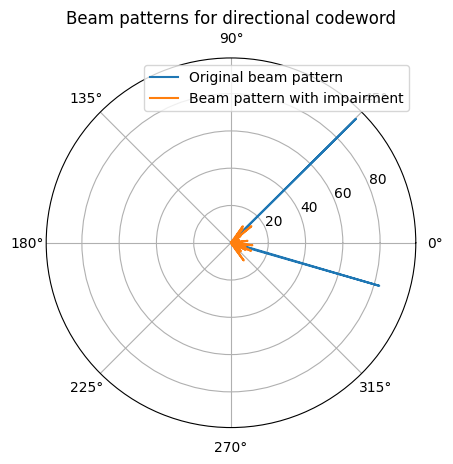

In [39]:
plt.figure()
plt.axes(projection='polar')
plt.polar(angle_sweep_vec, gain_w_d, '-')
plt.polar(angle_sweep_vec, gain_w_d_impaired, '-')
plt.title('Beam patterns for directional codeword')
plt.legend(['Original beam pattern','Beam pattern with impairment'])
plt.show()

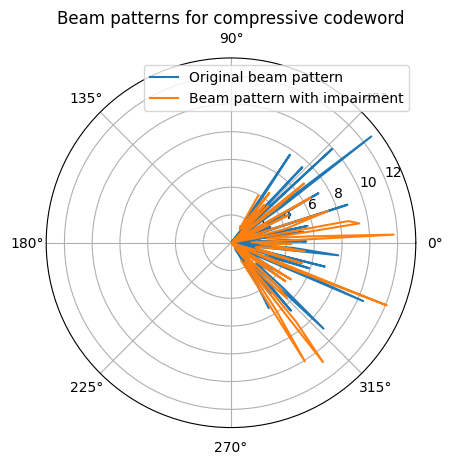

In [40]:
plt.figure()
plt.axes(projection='polar')
plt.polar(angle_sweep_vec, gain_w_s, '-')
plt.polar(angle_sweep_vec, gain_w_s_impaired, '-')
plt.title('Beam patterns for compressive codeword')
plt.legend(['Original beam pattern','Beam pattern with impairment'])
plt.show()

#### 2-4) Construct datasets for all experiments

##### Generate PyTorch Datasets

In [41]:
# Set batch size and check for CUDA
batch_size = 64
torch.cuda.empty_cache()
device_id = 0 if torch.cuda.is_available() else 'cpu'
device = torch.device(device_id)
print(device)

cuda:0


##### Preallocate data lists

###### Generate data for SNR sweep (M = 8)

In [42]:
# step 0: select SNR
# step 1: generate PSS features by varying noise (and with + w/o B)
# step 2: rename features
# step 3: train_val split
# step 4: assign features and labels to dictionary

list_M_8_SNR_dB_sweep_ideal = []
list_M_8_SNR_dB_sweep_impaired = []

choose_M = 8

# Use snr_range_dB
for ind, select_SNR_dB in enumerate(snr_range_dB):
  ##### ========== Generate noise using selected SNR ========== #####
  noise_mat_train = generate_awgn_matrix(np.ones(H_train.shape)*alpha_1/np.sqrt(N_R), select_SNR_dB)
  noise_mat_test = generate_awgn_matrix(np.ones(H_test.shape)*alpha_1/np.sqrt(N_R), select_SNR_dB)

  ##### ========== Compute PSS measurements (ideal and with impairments) ========== #####
  Y_PSS_train_val = np.power(np.abs(W_S.H @ (H_train + noise_mat_train)),2)
  Y_PSS_test = np.power(np.abs(W_S.H @ (H_test + noise_mat_test)),2)

  Y_PSS_impaired_train_val = np.power(np.abs(W_S.H @ B @ (H_train + noise_mat_train)),2) # np.power(np.abs(W_S.H @ B @ (H_train + noise_mat_train)),2)
  Y_PSS_impaired_test = np.power(np.abs(W_S.H @ B @ (H_test + noise_mat_test)),2) # np.power(np.abs(W_S.H @ B @ (H_test + noise_mat_test)),2)

  labels_train_val = ind_phi_1_train.copy()
  labels_test = ind_phi_1_test.copy()

  ##### ========== Select number of measurements based on M ========== #####
  m_sampled_measurements = np.arange(choose_M) # np.random.choice(np.arange(choose_M), size=choose_M, replace=False)

  ##### ========== Rename PSS measurements and labels (ideal and with impairments) ========== #####
  # Ideal
  X_train_val_np = Y_PSS_train_val[m_sampled_measurements,:].T
  y_train_val_np = labels_train_val

  X_test_np = Y_PSS_test[m_sampled_measurements,:].T
  y_test_np = labels_test

  # With impairments
  X_train_val_impaired_np = Y_PSS_impaired_train_val[m_sampled_measurements,:].T
  y_train_val_impaired_np = labels_train_val

  X_test_impaired_np = Y_PSS_impaired_test[m_sampled_measurements,:].T
  y_test_impaired_np = labels_test

  ##### ========== Split dataset into training and validation sets ========== #####
  ##### Without impairments
  X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_val_np,
                                                                y_train_val_np,
                                                                test_size=0.2,
                                                                random_state=42)

  ##### With impairments
  X_train_impaired_np, X_val_impaired_np, y_train_impaired_np, y_val_impaired_np = train_test_split(X_train_val_impaired_np,
                                                                                                    y_train_val_impaired_np,
                                                                                                    test_size=0.2,
                                                                                                    random_state=42)

  ##### ========== Store values in dictionary ========== #####
  list_M_8_SNR_dB_sweep_ideal.append(((X_train_np.copy(), y_train_np.copy()),
                                      (X_val_np.copy(), y_val_np.copy()),
                                      (X_test_np.copy(), y_test_np.copy())))

  list_M_8_SNR_dB_sweep_impaired.append(((X_train_impaired_np.copy(), y_train_impaired_np.copy()),
                                          (X_val_impaired_np.copy(), y_val_impaired_np.copy()),
                                          (X_test_impaired_np.copy(), y_test_impaired_np.copy())))


###### Generate data for M sweep (SNR = 20 dB)

In [43]:
Y_PSS_train_val.shape

(12, 1000)

In [44]:
# step 0: select M, for fixed SNR dB
# step 1: generate PSS features for all 12 measurements
# step 2: select M rows of Y as the measurements
# step 3: rename features
# step 4: train_val split
# step 5: assign features and labels to dictionary

list_SNR_dB_20_M_sweep_ideal = []
list_SNR_dB_20_M_sweep_impaired = []

M_range = np.array([4, 8, 12])
select_SNR_dB = 20

# Use snr_range_dB
for ind, choose_M in enumerate(M_range):
  ##### ========== Generate noise using selected SNR ========== #####
  noise_mat_train = generate_awgn_matrix(np.ones(H_train.shape)*alpha_1/np.sqrt(N_R), select_SNR_dB)
  noise_mat_test = generate_awgn_matrix(np.ones(H_test.shape)*alpha_1/np.sqrt(N_R), select_SNR_dB)

  ##### ========== Compute PSS measurements (ideal and with impairments) ========== #####
  Y_PSS_train_val = np.power(np.abs(W_S.H @ (H_train + noise_mat_train)),2)
  Y_PSS_test = np.power(np.abs(W_S.H @ (H_test + noise_mat_test)),2)

  Y_PSS_impaired_train_val = np.power(np.abs(W_S.H @ B @ (H_train + noise_mat_train)),2) # np.power(np.abs(W_S.H @ B @ (H_train + noise_mat_train)),2)
  Y_PSS_impaired_test = np.power(np.abs(W_S.H @ B @ (H_test + noise_mat_test)),2) # np.power(np.abs(W_S.H @ B @ (H_test + noise_mat_test)),2)

  labels_train_val = ind_phi_1_train.copy()
  labels_test = ind_phi_1_test.copy()

  ##### ========== Select number of measurements based on M ========== #####
  m_sampled_measurements = np.arange(choose_M) # np.random.choice(np.arange(choose_M), size=choose_M, replace=False) # np.arange(choose_M)

  ##### ========== Rename PSS measurements and labels (ideal and with impairments) ========== #####
  # Ideal
  X_train_val_np = Y_PSS_train_val[m_sampled_measurements,:].T
  y_train_val_np = labels_train_val

  X_test_np = Y_PSS_test[m_sampled_measurements,:].T
  y_test_np = labels_test

  # With impairments
  X_train_val_impaired_np = Y_PSS_impaired_train_val[m_sampled_measurements,:].T
  y_train_val_impaired_np = labels_train_val

  X_test_impaired_np = Y_PSS_impaired_test[m_sampled_measurements,:].T
  y_test_impaired_np = labels_test

  ##### ========== Split dataset into training and validation sets ========== #####
  ##### Without impairments
  X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_val_np,
                                                                y_train_val_np,
                                                                test_size=0.2,
                                                                random_state=42)

  ##### With impairments
  X_train_impaired_np, X_val_impaired_np, y_train_impaired_np, y_val_impaired_np = train_test_split(X_train_val_impaired_np,
                                                                                                    y_train_val_impaired_np,
                                                                                                    test_size=0.2,
                                                                                                    random_state=42)

  print(X_train_np.shape)
  ##### ========== Store values in dictionary ========== #####
  list_SNR_dB_20_M_sweep_ideal.append(((X_train_np.copy(), y_train_np.copy()),
                                      (X_val_np.copy(), y_val_np.copy()),
                                      (X_test_np.copy(), y_test_np.copy())))

  list_SNR_dB_20_M_sweep_impaired.append(((X_train_impaired_np.copy(), y_train_impaired_np.copy()),
                                          (X_val_impaired_np.copy(), y_val_impaired_np.copy()),
                                          (X_test_impaired_np.copy(), y_test_impaired_np.copy())))



(800, 4)
(800, 8)
(800, 12)


###### Generate data for secondary path sweep (M = 8, SNR = 20 dB)

In [45]:
# step 0: select alpha_2 and generate new H, for fixed M and fixed SNR dB
# step 1: generate PSS features for all 8 measurements
# step 2: generate new labels for each H
# step 3: select M rows of Y as the measurements
# step 4: rename features
# step 5: train_val split
# step 6: assign features and labels to dictionary

list_SNR_dB_20_M_8_secondary_L_2_sweep_ideal = []
list_SNR_dB_20_M_8_secondary_L_2_sweep_impaired = []

choose_M = 8
select_SNR_dB = 20
secondary_gain_range = np.arange(-15,-2,3)

# Use rel_gain_dB
for ind, rel_gain_dB in enumerate(secondary_gain_range):
  ##### ========== Generate temp_H ========== #####
  # temp_H_train represents temp_H_train_val
  n_training_instances = 1000
  angle_spacing_rad = 10*np.pi/180 # Ensure at least 10 degree spacing between angles
  temp_ind_phi_1_train, temp_ind_phi_2_train, temp_H_train = generate_channel_matrix(N_R, n_training_instances,
                                                                                     alpha_1,
                                                                                     AoA_vec_K,
                                                                                     angle_spacing_rad,
                                                                                     secondary_path_gain_dB=rel_gain_dB,L=2)

  n_testing_instances = 400
  angle_spacing_rad = 10*np.pi/180 # Ensure at least 10 degree spacing between angles
  temp_ind_phi_1_test, temp_ind_phi_2_test, temp_H_test = generate_channel_matrix(N_R, n_testing_instances,
                                                                                  alpha_1,
                                                                                  AoA_vec_K,
                                                                                  angle_spacing_rad,
                                                                                  secondary_path_gain_dB=rel_gain_dB,L=2)


  ##### ========== Generate noise using selected SNR ========== #####
  temp_noise_mat_train = generate_awgn_matrix(np.ones(temp_H_train.shape)*alpha_1/np.sqrt(N_R), select_SNR_dB)
  temp_noise_mat_test = generate_awgn_matrix(np.ones(temp_H_test.shape)*alpha_1/np.sqrt(N_R), select_SNR_dB)

  ##### ========== Compute PSS measurements (ideal and with impairments) ========== #####
  Y_PSS_train_val = np.power(np.abs(W_S.H @ (temp_H_train + temp_noise_mat_train)),2)
  Y_PSS_test = np.power(np.abs(W_S.H @ (temp_H_test + temp_noise_mat_test)),2)

  Y_PSS_impaired_train_val = np.power(np.abs(W_S.H @ B @ (temp_H_train + temp_noise_mat_train)),2) # np.power(np.abs(W_S.H @ B @ (temp_H_train + temp_noise_mat_train)),2)
  Y_PSS_impaired_test = np.power(np.abs(W_S.H @ B @ (temp_H_test + temp_noise_mat_test)),2) # np.power(np.abs(W_S.H @ B @ (temp_H_test + temp_noise_mat_test)),2)

  labels_train_val = temp_ind_phi_1_train.copy()
  labels_test = temp_ind_phi_1_test.copy()

  ##### ========== Select number of measurements based on M ========== #####
  m_sampled_measurements = np.arange(choose_M) # np.random.choice(np.arange(choose_M), size=choose_M, replace=False) # np.arange(choose_M)

  ##### ========== Rename PSS measurements and labels (ideal and with impairments) ========== #####
  # Ideal
  X_train_val_np = Y_PSS_train_val[m_sampled_measurements,:].T
  y_train_val_np = labels_train_val.copy()

  X_test_np = Y_PSS_test[m_sampled_measurements,:].T
  y_test_np = labels_test.copy()

  # With impairments
  X_train_val_impaired_np = Y_PSS_impaired_train_val[m_sampled_measurements,:].T
  y_train_val_impaired_np = labels_train_val.copy()

  X_test_impaired_np = Y_PSS_impaired_test[m_sampled_measurements,:].T
  y_test_impaired_np = labels_test.copy()

  ##### ========== Split dataset into training and validation sets ========== #####
  ##### Without impairments
  X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_val_np,
                                                                y_train_val_np,
                                                                test_size=0.2,
                                                                random_state=42)

  ##### With impairments
  X_train_impaired_np, X_val_impaired_np, y_train_impaired_np, y_val_impaired_np = train_test_split(X_train_val_impaired_np,
                                                                                                    y_train_val_impaired_np,
                                                                                                    test_size=0.2,
                                                                                                    random_state=42)

  print(X_train_np.shape)
  ##### ========== Store values in dictionary ========== #####
  list_SNR_dB_20_M_8_secondary_L_2_sweep_ideal.append(((X_train_np.copy(), y_train_np.copy()),
                                      (X_val_np.copy(), y_val_np.copy()),
                                      (X_test_np.copy(), y_test_np.copy())))

  list_SNR_dB_20_M_8_secondary_L_2_sweep_impaired.append(((X_train_impaired_np.copy(), y_train_impaired_np.copy()),
                                          (X_val_impaired_np.copy(), y_val_impaired_np.copy()),
                                          (X_test_impaired_np.copy(), y_test_impaired_np.copy())))




(800, 8)
(800, 8)
(800, 8)
(800, 8)
(800, 8)


##### PyTorch train and validation DataLoaders with test tensors

##### train_val_test_torch_tuple(tuple_train_val_test)

In [46]:
def train_val_test_torch_tuple(tuple_train_val_test):
  '''
  Input: A 3-tuple of the form ((X_train, y_train), (X_val, y_val), (X_test, y_test))
  Return: The 3-tuple (sel_train_dataloader, sel_val_dataloader, (select_X_test_nn, select_y_test_nn))
  '''
  select_X_train_np, select_y_train_np = tuple_train_val_test[0]
  select_X_val_np, select_y_val_np = tuple_train_val_test[1]
  select_X_test_np, select_y_test_np = tuple_train_val_test[2]

  #print(select_X_train_np.shape)
  #print(select_X_val_np.shape)
  #print(select_X_test_np.shape)
  device_id = 0 if torch.cuda.is_available() else 'cpu'
  device = torch.device(device_id)

  sel_train_dataset = ConstructDataset(select_X_train_np, select_y_train_np)
  sel_train_dataloader = torch.utils.data.DataLoader(sel_train_dataset, batch_size=batch_size, shuffle=False) ##### Use this
  sel_val_dataset = ConstructDataset(select_X_val_np, select_y_val_np)
  sel_val_dataloader = torch.utils.data.DataLoader(sel_val_dataset, batch_size=batch_size, shuffle=False)  ##### Use this

  # Test data
  select_X_test_nn = torch.FloatTensor(select_X_test_np.copy()).to(device)
  select_y_test_nn = torch.LongTensor(select_y_test_np.copy()).to(device)

  return (sel_train_dataloader, sel_val_dataloader, (select_X_test_nn, select_y_test_nn))


In [47]:
#my_tuple = train_val_test_torch_tuple(data_M_8_SNR_dB_sweep['ideal']['20'])[0]

##### train_validate_test_mmRAPID(train_dataloader, val_dataloader, X_test_nn, y_test_nn, select_M=12, select_K=64, n_epochs=200,loss_fn=nn.CrossEntropyLoss(),select_lr=0.01,select_weight_decay=0.01):


In [48]:
def train_validate_test_mmRAPID(train_dataloader, val_dataloader, X_test_nn, y_test_nn, select_M=12, select_K=64, n_epochs=200,loss_fn=nn.CrossEntropyLoss(),select_lr=0.001,select_weight_decay=0.01):
  '''
  Returns:
  A dictionary with keys 'model', 'train_results', 'val_results', and 'test_results'
  '''

  '''
  ##### ============== Train and validate model ============== #####
  '''
  torch.manual_seed(42)
  random.seed(42)
  np.random.seed(42)

  batch_size = 64
  torch.cuda.empty_cache()
  device_id = 0 if torch.cuda.is_available() else 'cpu'
  device = torch.device(device_id)

  num_epochs = n_epochs
  M = select_M
  K = select_K

  model = mmRAPID_MLP(M, K).to(device)
  optimizer = torch.optim.RMSprop(model.parameters(), lr=select_lr, weight_decay=select_weight_decay) # Adam
  loss_fn = nn.CrossEntropyLoss()

  ##### ========== Preallocate train-val loss/accuracy histories ========== #####
  train_loss_hist = []
  val_loss_hist = []
  train_acc_hist = []
  val_acc_hist = []
  ##### =================================================================== #####

  pbar = tqdm(range(num_epochs))
  #####
  for epoch in pbar:
    ##### ========== Train model ========== #####
    model.train()
    for batch in train_dataloader:
      optimizer.zero_grad()
      x, y = batch
      x = x.to(device)
      y = y.to(device)

      out = model(x)
      loss = loss_fn(out, y)
      loss.backward()
      optimizer.step()

      train_loss_hist.append(loss.item()) # Save training loss

    ##### ========== Evaluate model ========== #####
    model.eval()

    ##### Training accuracy
    y_hat_epoch_train = []
    y_true_epoch_train = []
    with torch.no_grad():
      for batch in train_dataloader:
        x, y = batch
        out = model(x)
        y_hat_train = out.argmax(dim=1).detach().cpu().numpy()
        y_true_train = y.detach().cpu().numpy()

        y_hat_epoch_train.append(y_hat_train)
        y_true_epoch_train.append(y_true_train)


    y_hat_epoch_train = np.concatenate(y_hat_epoch_train).reshape((-1,))
    y_true_epoch_train = np.concatenate(y_true_epoch_train).reshape((-1,))

    epoch_train_acc = accuracy_score(y_hat_epoch_train, y_true_epoch_train)
    train_acc_hist.append(epoch_train_acc) # Save training acc

    ##### Validation loss and accuracy
    y_hat_epoch_val = []
    y_true_epoch_val = []
    with torch.no_grad():
      for batch in val_dataloader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        out = model(x)
        val_loss = loss_fn(out,y)
        val_loss_hist.append(val_loss.item())

        y_hat_val = out.argmax(dim=1).detach().cpu().numpy()
        y_true_val = y.detach().cpu().numpy()

        y_hat_epoch_val.append(y_hat_val)
        y_true_epoch_val.append(y_true_val)



    y_hat_epoch_val = np.concatenate(y_hat_epoch_val).reshape((-1,))
    y_true_epoch_val = np.concatenate(y_true_epoch_val).reshape((-1,))

    epoch_val_acc = accuracy_score(y_hat_epoch_val, y_true_epoch_val)
    val_acc_hist.append(epoch_val_acc) # Save valing acc



  ##### Print training and testing results
  print('\nTrain accuracy: ' + str(train_acc_hist[-1]) + ' , Train loss: ' + str(train_loss_hist[-1]))
  print('Val accuracy: ' + str(val_acc_hist[-1])  + ' , Val loss: ' + str(val_loss_hist[-1]))
  '''
  ##### ============== Test model ============== #####
  '''
  model.eval()
  y_hat_test_np = model(X_test_nn).argmax(dim=1).detach().cpu().numpy()
  y_test_np = y_test_nn.detach().cpu().numpy()

  test_acc = accuracy_score(y_test_np, y_hat_test_np)
  print('Test accuracy: ' + str(test_acc))

  ##### Compute RMSE between estimated angles and actual angles for given SNR
  test_RMSE_for_SNR = np.sqrt(mean_squared_error(AoA_vec_K[y_test_np], AoA_vec_K[y_hat_test_np]))
  print('RMSE = ' + str(test_RMSE_for_SNR))


  '''
  ##### ============== Construct dictionaries ============== #####
  '''
  train_results = {'train_acc_hist': train_acc_hist.copy(), 'train_loss_hist': train_loss_hist.copy()}
  val_results = {'val_acc_hist': val_acc_hist.copy(), 'val_loss_hist': val_loss_hist.copy()}
  test_results = {'test_accuracy': test_acc.copy(), 'RMSE': test_RMSE_for_SNR.copy()}

  return {'model': deepcopy(model),
          'train_results': train_results.copy(),
          'val_results': val_results.copy(),
          'test_results': test_results.copy()}


##### Data list lengths

In [49]:
print('dB sweep')
print('SNR dB range: ', snr_range_dB)
print(len(list_M_8_SNR_dB_sweep_ideal))
print(len(list_M_8_SNR_dB_sweep_impaired))

print('\nM sweep')
print('M sweep range:', M_range)
print(len(list_SNR_dB_20_M_sweep_ideal))
print(len(list_SNR_dB_20_M_sweep_impaired))

print('\nL sweep', secondary_gain_range)
print(len(list_SNR_dB_20_M_8_secondary_L_2_sweep_ideal))
print(len(list_SNR_dB_20_M_8_secondary_L_2_sweep_impaired))

dB sweep
SNR dB range:  [ 0  5 10 15 20 25 30]
7
7

M sweep
M sweep range: [ 4  8 12]
3
3

L sweep [-15 -12  -9  -6  -3]
5
5


#### 2-4) Train-val loss sandbox

In [50]:
#my_model = train_validate_test_mmRAPID(train_dataloader, val_dataloader, X_test_nn, y_test_nn, select_M=8)
dB_sweep_data_ideal = list_M_8_SNR_dB_sweep_ideal[3]
dB_sweep_data_impaired = list_M_8_SNR_dB_sweep_impaired[3]

M_sweep_data_ideal = list_SNR_dB_20_M_sweep_ideal[2]
M_sweep_data_impaired = list_SNR_dB_20_M_sweep_impaired[2]

L_sweep_data_ideal = list_SNR_dB_20_M_8_secondary_L_2_sweep_ideal[0]
L_sweep_impaired = list_SNR_dB_20_M_8_secondary_L_2_sweep_impaired[1]

my_tuple = train_val_test_torch_tuple(dB_sweep_data_impaired)
my_model = train_validate_test_mmRAPID(my_tuple[0], my_tuple[1], my_tuple[2][0], my_tuple[2][1], select_M=8,
                                       n_epochs=150,loss_fn=nn.CrossEntropyLoss())

print(my_model['model'])

100%|██████████| 150/150 [00:08<00:00, 17.10it/s]


Train accuracy: 0.8025 , Train loss: 0.5666450262069702
Val accuracy: 0.715 , Val loss: 1.2625434398651123
Test accuracy: 0.765
RMSE = 0.49596539679576984
mmRAPID_MLP(
  (relu): ReLU()
  (linear_bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=8, out_features=64, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (linear_bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
)


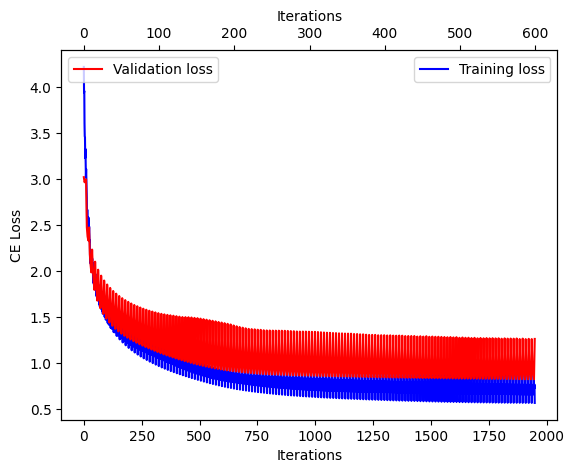

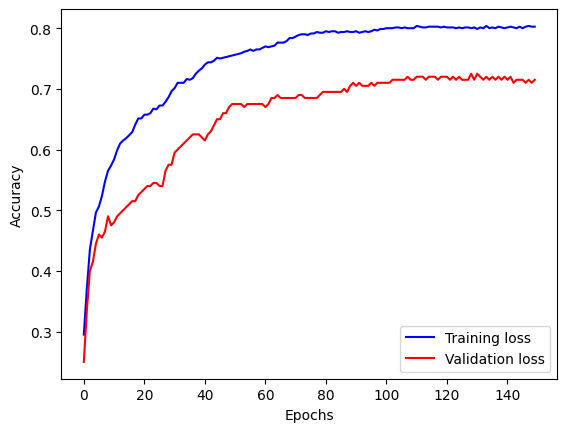

In [51]:
plt.figure()
plt.plot(my_model['train_results']['train_loss_hist'],'b-',label='Training loss')
plt.legend(loc='upper right')
plt.xlabel('Iterations')
plt.ylabel('CE Loss')
plt.twiny()
plt.plot(my_model['val_results']['val_loss_hist'],'r-',label='Validation loss')
plt.legend(loc='upper left')
plt.xlabel('Iterations')
plt.ylabel('CE Loss')
plt.show()

plt.figure()
plt.plot(my_model['train_results']['train_acc_hist'],'b-',label='Training loss')
plt.plot(my_model['val_results']['val_acc_hist'],'r-',label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()


#### 2) RMSE of AoA vs RMSE with a -15 dB secondary path gain, M = 8

In [52]:
M_sweep_ideal_RMSE_hist = []
M_sweep_impaired_RMSE_hist = []

M_sweep_ideal_models = []
M_sweep_impaired_models = []

num_epochs = 150

for ind, select_snr in enumerate(snr_range_dB):
  dB_sweep_data_ideal = list_M_8_SNR_dB_sweep_ideal[ind]
  dB_sweep_data_impaired = list_M_8_SNR_dB_sweep_impaired[ind]

  data_tuple_ideal = train_val_test_torch_tuple(dB_sweep_data_ideal)
  data_tuple_impaired = train_val_test_torch_tuple(dB_sweep_data_impaired)

  print('===============')
  print('Ideal: ' + 'SNR = ' + str(select_snr) + ' dB')
  my_model_ideal = train_validate_test_mmRAPID(data_tuple_ideal[0], data_tuple_ideal[1],
                                         data_tuple_ideal[2][0], data_tuple_ideal[2][1],
                                         select_M=8, n_epochs=num_epochs,loss_fn=nn.CrossEntropyLoss())

  print('\nImpaired: ' + 'SNR = ' + str(select_snr) + ' dB')
  my_model_impaired = train_validate_test_mmRAPID(data_tuple_impaired[0], data_tuple_impaired[1],
                                        data_tuple_impaired[2][0], data_tuple_impaired[2][1],
                                        select_M=8, n_epochs=num_epochs,loss_fn=nn.CrossEntropyLoss())

  M_sweep_ideal_RMSE_hist.append(my_model_ideal['test_results']['RMSE'])
  M_sweep_impaired_RMSE_hist.append(my_model_impaired['test_results']['RMSE'])

  M_sweep_ideal_models.append(my_model_ideal['model'])
  M_sweep_impaired_models.append(my_model_impaired['model'])

Ideal: SNR = 0 dB


100%|██████████| 150/150 [00:05<00:00, 25.16it/s]



Train accuracy: 0.21375 , Train loss: 2.197476863861084
Val accuracy: 0.11 , Val loss: 3.615098237991333
Test accuracy: 0.1175
RMSE = 0.822482361786318

Impaired: SNR = 0 dB


100%|██████████| 150/150 [00:05<00:00, 26.11it/s]



Train accuracy: 0.23125 , Train loss: 2.290365695953369
Val accuracy: 0.085 , Val loss: 3.1843907833099365
Test accuracy: 0.1325
RMSE = 0.8210651934610743
Ideal: SNR = 5 dB


100%|██████████| 150/150 [00:05<00:00, 26.03it/s]



Train accuracy: 0.4925 , Train loss: 1.3146332502365112
Val accuracy: 0.31 , Val loss: 2.032360792160034
Test accuracy: 0.345
RMSE = 0.7906954401304306

Impaired: SNR = 5 dB


100%|██████████| 150/150 [00:05<00:00, 26.45it/s]



Train accuracy: 0.465 , Train loss: 1.466805338859558
Val accuracy: 0.28 , Val loss: 2.287228584289551
Test accuracy: 0.3025
RMSE = 0.7730369712516871
Ideal: SNR = 10 dB


100%|██████████| 150/150 [00:05<00:00, 25.61it/s]



Train accuracy: 0.74375 , Train loss: 0.7090141773223877
Val accuracy: 0.61 , Val loss: 1.6865191459655762
Test accuracy: 0.62
RMSE = 0.547475776835059

Impaired: SNR = 10 dB


100%|██████████| 150/150 [00:05<00:00, 26.17it/s]



Train accuracy: 0.69625 , Train loss: 0.7320276498794556
Val accuracy: 0.505 , Val loss: 1.3665522336959839
Test accuracy: 0.5875
RMSE = 0.6220073426511593
Ideal: SNR = 15 dB


100%|██████████| 150/150 [00:05<00:00, 25.00it/s]



Train accuracy: 0.83375 , Train loss: 0.4593346416950226
Val accuracy: 0.715 , Val loss: 1.0413718223571777
Test accuracy: 0.7825
RMSE = 0.4672785185616325

Impaired: SNR = 15 dB


100%|██████████| 150/150 [00:05<00:00, 26.10it/s]



Train accuracy: 0.8025 , Train loss: 0.5666450262069702
Val accuracy: 0.715 , Val loss: 1.2625434398651123
Test accuracy: 0.765
RMSE = 0.49596539679576984
Ideal: SNR = 20 dB


100%|██████████| 150/150 [00:06<00:00, 24.71it/s]



Train accuracy: 0.85875 , Train loss: 0.4116485118865967
Val accuracy: 0.785 , Val loss: 1.0336309671401978
Test accuracy: 0.8425
RMSE = 0.3823752548976361

Impaired: SNR = 20 dB


100%|██████████| 150/150 [00:05<00:00, 25.39it/s]



Train accuracy: 0.83875 , Train loss: 0.49808675050735474
Val accuracy: 0.79 , Val loss: 1.134735345840454
Test accuracy: 0.835
RMSE = 0.4094931462147735
Ideal: SNR = 25 dB


100%|██████████| 150/150 [00:05<00:00, 25.61it/s]



Train accuracy: 0.87625 , Train loss: 0.3829042613506317
Val accuracy: 0.785 , Val loss: 1.1805942058563232
Test accuracy: 0.8525
RMSE = 0.33455628279002886

Impaired: SNR = 25 dB


100%|██████████| 150/150 [00:05<00:00, 25.38it/s]



Train accuracy: 0.845 , Train loss: 0.5069015026092529
Val accuracy: 0.775 , Val loss: 1.0333162546157837
Test accuracy: 0.835
RMSE = 0.37066723478806435
Ideal: SNR = 30 dB


100%|██████████| 150/150 [00:06<00:00, 24.98it/s]



Train accuracy: 0.88 , Train loss: 0.3720189034938812
Val accuracy: 0.78 , Val loss: 1.0386782884597778
Test accuracy: 0.8475
RMSE = 0.39790951740846675

Impaired: SNR = 30 dB


100%|██████████| 150/150 [00:05<00:00, 25.75it/s]


Train accuracy: 0.8475 , Train loss: 0.4775271713733673
Val accuracy: 0.76 , Val loss: 1.0349538326263428
Test accuracy: 0.8375
RMSE = 0.3767373028346826


###### RMSE plot

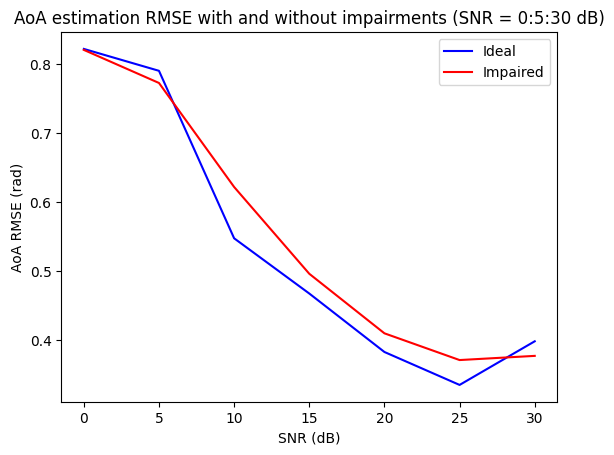

In [53]:
plt.figure()
plt.plot(snr_range_dB, M_sweep_ideal_RMSE_hist,'b-',label='Ideal')
plt.plot(snr_range_dB, M_sweep_impaired_RMSE_hist,'r-',label='Impaired')
plt.xlabel('SNR (dB)')
plt.ylabel('AoA RMSE (rad)')
plt.legend()
plt.title('AoA estimation RMSE with and without impairments (SNR = 0:5:30 dB)')
plt.show()


#### 3) RMSE of AoA with a - 15 dB secondary path gain and 20 dB SNR

In [54]:
SNR_sweep_ideal_RMSE_hist = []
SNR_sweep_impaired_RMSE_hist = []

SNR_sweep_ideal_models = []
SNR_sweep_impaired_models = []

num_epochs = 150

for ind, sel_M in enumerate(M_range):
  M_sweep_data_ideal = list_SNR_dB_20_M_sweep_ideal[ind]
  M_sweep_data_impaired = list_SNR_dB_20_M_sweep_impaired[ind]

  data_tuple_ideal = train_val_test_torch_tuple(M_sweep_data_ideal)
  data_tuple_impaired = train_val_test_torch_tuple(M_sweep_data_impaired)

  print('===============')
  print('Ideal: ' + 'M = ' + str(sel_M))
  my_model_ideal = train_validate_test_mmRAPID(data_tuple_ideal[0], data_tuple_ideal[1],
                                         data_tuple_ideal[2][0], data_tuple_ideal[2][1],
                                         select_M=sel_M, n_epochs=num_epochs,loss_fn=nn.CrossEntropyLoss())

  print('\nImpaired: ' + 'M = ' + str(sel_M))
  my_model_impaired = train_validate_test_mmRAPID(data_tuple_impaired[0], data_tuple_impaired[1],
                                        data_tuple_impaired[2][0], data_tuple_impaired[2][1],
                                        select_M=sel_M, n_epochs=num_epochs,loss_fn=nn.CrossEntropyLoss())

  SNR_sweep_ideal_RMSE_hist.append(my_model_ideal['test_results']['RMSE'])
  SNR_sweep_impaired_RMSE_hist.append(my_model_impaired['test_results']['RMSE'])

  SNR_sweep_ideal_models.append(my_model_ideal['model'])
  SNR_sweep_impaired_models.append(my_model_impaired['model'])

Ideal: M = 4


100%|██████████| 150/150 [00:05<00:00, 25.37it/s]



Train accuracy: 0.63125 , Train loss: 1.096755027770996
Val accuracy: 0.55 , Val loss: 1.4266871213912964
Test accuracy: 0.625
RMSE = 0.5397578966136787

Impaired: M = 4


100%|██████████| 150/150 [00:05<00:00, 25.32it/s]



Train accuracy: 0.62 , Train loss: 1.3318065404891968
Val accuracy: 0.51 , Val loss: 1.5915123224258423
Test accuracy: 0.6075
RMSE = 0.6088281684116449
Ideal: M = 8


100%|██████████| 150/150 [00:05<00:00, 25.26it/s]



Train accuracy: 0.86375 , Train loss: 0.3923383355140686
Val accuracy: 0.74 , Val loss: 1.1816905736923218
Test accuracy: 0.8475
RMSE = 0.36824045343923656

Impaired: M = 8


100%|██████████| 150/150 [00:05<00:00, 25.95it/s]



Train accuracy: 0.83375 , Train loss: 0.5593792200088501
Val accuracy: 0.775 , Val loss: 1.1807150840759277
Test accuracy: 0.8375
RMSE = 0.3799505346303082
Ideal: M = 12


100%|██████████| 150/150 [00:06<00:00, 23.99it/s]



Train accuracy: 0.91 , Train loss: 0.30426785349845886
Val accuracy: 0.835 , Val loss: 0.8124861717224121
Test accuracy: 0.875
RMSE = 0.3874466568147559

Impaired: M = 12


100%|██████████| 150/150 [00:06<00:00, 24.74it/s]


Train accuracy: 0.895 , Train loss: 0.34058985114097595
Val accuracy: 0.78 , Val loss: 0.990787923336029
Test accuracy: 0.8775
RMSE = 0.311425377431605


###### RMSE plot


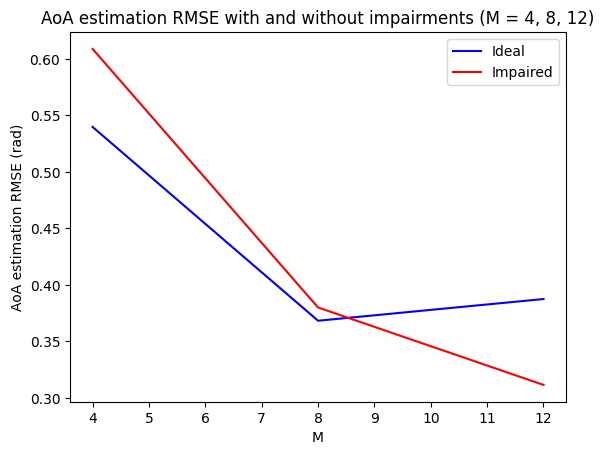

In [55]:
plt.figure()
plt.plot(M_range, SNR_sweep_ideal_RMSE_hist,'b-',label='Ideal')
plt.plot(M_range, SNR_sweep_impaired_RMSE_hist,'r-',label='Impaired')
plt.xlabel('M')
plt.ylabel('AoA estimation RMSE (rad)')
plt.legend()
plt.title('AoA estimation RMSE with and without impairments (M = 4, 8, 12)')
plt.show()

#### 4) RMSE of AoA with adjustable secondary path gain and 20 dB SNR

In [56]:
  '''
  M_sweep_data_ideal = list_SNR_dB_20_M_sweep_ideal[1] # M = 8
  M_sweep_data_impaired = list_SNR_dB_20_M_sweep_impaired[1] # M = 8

  data_tuple_ideal = train_val_test_torch_tuple(M_sweep_data_ideal) # M = 8
  data_tuple_impaired = train_val_test_torch_tuple(M_sweep_data_impaired) # M = 8

  load_ideal_model = deepcopy(train_validate_test_mmRAPID(data_tuple_ideal[0], data_tuple_ideal[1],
                                         data_tuple_ideal[2][0], data_tuple_ideal[2][1],
                                         select_M=8, n_epochs=num_epochs,loss_fn=nn.CrossEntropyLoss())['model'])

  load_ideal_model.eval()


  load_impaired_model = deepcopy(train_validate_test_mmRAPID(data_tuple_impaired[0], data_tuple_impaired[1],
                                        data_tuple_impaired[2][0], data_tuple_impaired[2][1],
                                        select_M=8, n_epochs=num_epochs,loss_fn=nn.CrossEntropyLoss())['model'])

  load_impaired_model.eval()
  '''

"\nM_sweep_data_ideal = list_SNR_dB_20_M_sweep_ideal[1] # M = 8\nM_sweep_data_impaired = list_SNR_dB_20_M_sweep_impaired[1] # M = 8\n\ndata_tuple_ideal = train_val_test_torch_tuple(M_sweep_data_ideal) # M = 8\ndata_tuple_impaired = train_val_test_torch_tuple(M_sweep_data_impaired) # M = 8\n\nload_ideal_model = deepcopy(train_validate_test_mmRAPID(data_tuple_ideal[0], data_tuple_ideal[1],\n                                       data_tuple_ideal[2][0], data_tuple_ideal[2][1],\n                                       select_M=8, n_epochs=num_epochs,loss_fn=nn.CrossEntropyLoss())['model'])\n\nload_ideal_model.eval()\n\n\nload_impaired_model = deepcopy(train_validate_test_mmRAPID(data_tuple_impaired[0], data_tuple_impaired[1],\n                                      data_tuple_impaired[2][0], data_tuple_impaired[2][1],\n                                      select_M=8, n_epochs=num_epochs,loss_fn=nn.CrossEntropyLoss())['model'])\n\nload_impaired_model.eval()\n"

In [57]:
load_ideal_model = deepcopy(SNR_sweep_ideal_models[1]) # M = 8, L = -15, SNR = 20
load_ideal_model.eval()
load_impaired_model = deepcopy(SNR_sweep_impaired_models[1]) # M = 8, L = -15, SNR = 20
load_impaired_model.eval()

mmRAPID_MLP(
  (relu): ReLU()
  (linear_bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear1): Linear(in_features=8, out_features=64, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (linear_bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear2): Linear(in_features=64, out_features=128, bias=True)
  (drop2): Dropout(p=0.5, inplace=False)
  (linear3): Linear(in_features=128, out_features=64, bias=True)
)

In [58]:
L_sweep_ideal_RMSE_hist = []
L_sweep_impaired_RMSE_hist = []

num_epochs = 150

for ind, sel_secondary_gain in enumerate(secondary_gain_range):
  L_sweep_data_ideal = list_SNR_dB_20_M_8_secondary_L_2_sweep_ideal[ind]
  L_sweep_impaired = list_SNR_dB_20_M_8_secondary_L_2_sweep_impaired[ind]

  data_tuple_ideal = train_val_test_torch_tuple(L_sweep_data_ideal)
  data_tuple_impaired = train_val_test_torch_tuple(L_sweep_impaired)

  X_test_nn_ideal, y_test_nn_ideal = data_tuple_ideal[2][0], data_tuple_ideal[2][1]
  X_test_nn_impaired, y_test_nn_impaired = data_tuple_impaired[2][0], data_tuple_impaired[2][1]

  ##### ========================= Ideal ========================= #####
  #my_model_ideal = train_validate_test_mmRAPID(data_tuple_ideal[0], data_tuple_ideal[1],
  #                                       data_tuple_ideal[2][0], data_tuple_ideal[2][1],
  #                                       select_M=8, n_epochs=num_epochs,loss_fn=nn.CrossEntropyLoss())

  print('===============')
  print('Ideal: ' + 'L = ' + str(sel_secondary_gain) + ' dB')
  y_hat_test_np_ideal = load_ideal_model(X_test_nn_ideal).argmax(dim=1).detach().cpu().numpy()
  y_test_np_ideal = y_test_nn_ideal.detach().cpu().numpy()

  # Compute accuracy
  test_acc_ideal = accuracy_score(y_test_np_ideal, y_hat_test_np_ideal)
  print('Accuracy = ' + str(test_acc_ideal))
  # Compute RMSE
  test_RMSE_for_SNR_ideal = np.sqrt(mean_squared_error(AoA_vec_K[y_test_np_ideal], AoA_vec_K[y_hat_test_np_ideal]))
  print('RMSE = ' + str(test_RMSE_for_SNR_ideal))


  ##### ========================= Impaired ========================= #####
  #my_model_impaired = train_validate_test_mmRAPID(data_tuple_impaired[0], data_tuple_impaired[1],
  #                                      data_tuple_impaired[2][0], data_tuple_impaired[2][1],
  #                                      select_M=8, n_epochs=num_epochs,loss_fn=nn.CrossEntropyLoss())

  print('\nImpaired: ' + 'L = ' + str(sel_secondary_gain) + ' dB')
  y_hat_test_np_impaired = load_impaired_model(X_test_nn_impaired).argmax(dim=1).detach().cpu().numpy()
  y_test_np_impaired = y_test_nn_impaired.detach().cpu().numpy()

  # Compute accuracy
  test_acc_impaired = accuracy_score(y_test_np_impaired, y_hat_test_np_impaired)
  print('Accuracy = ' + str(test_acc_impaired))
  # Compute RMSE
  test_RMSE_for_SNR_impaired = np.sqrt(mean_squared_error(AoA_vec_K[y_test_np_impaired], AoA_vec_K[y_hat_test_np_impaired]))
  print('RMSE = ' + str(test_RMSE_for_SNR_impaired))


  L_sweep_ideal_RMSE_hist.append(test_RMSE_for_SNR_ideal) #my_model_ideal['test_results']['RMSE'])
  L_sweep_impaired_RMSE_hist.append(test_RMSE_for_SNR_impaired) #my_model_impaired['test_results']['RMSE'])

Ideal: L = -15 dB
Accuracy = 0.8325
RMSE = 0.3891437375426482

Impaired: L = -15 dB
Accuracy = 0.8275
RMSE = 0.3755914652537094
Ideal: L = -12 dB
Accuracy = 0.7825
RMSE = 0.4142326799224959

Impaired: L = -12 dB
Accuracy = 0.7675
RMSE = 0.4522975199095734
Ideal: L = -9 dB
Accuracy = 0.665
RMSE = 0.5231790951584308

Impaired: L = -9 dB
Accuracy = 0.5875
RMSE = 0.5988347740331694
Ideal: L = -6 dB
Accuracy = 0.4425
RMSE = 0.6760734649791678

Impaired: L = -6 dB
Accuracy = 0.385
RMSE = 0.6949842002489565
Ideal: L = -3 dB
Accuracy = 0.25
RMSE = 0.7438385262437152

Impaired: L = -3 dB
Accuracy = 0.1925
RMSE = 0.7969847249969804


###### RMSE plot

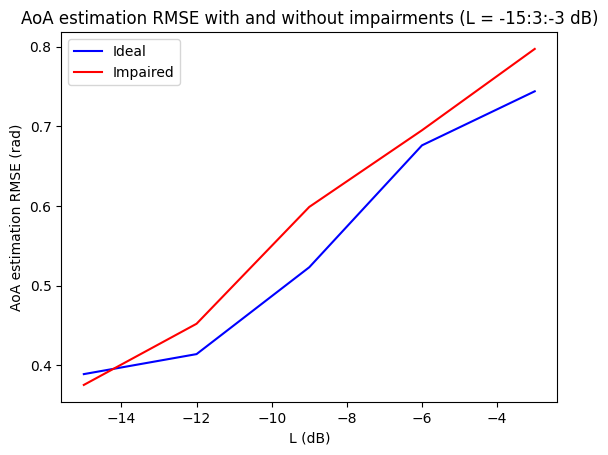

In [59]:
plt.figure()
plt.plot(secondary_gain_range, L_sweep_ideal_RMSE_hist,'b-',label='Ideal')
plt.plot(secondary_gain_range, L_sweep_impaired_RMSE_hist,'r-',label='Impaired')
plt.xlabel('L (dB)')
plt.ylabel('AoA estimation RMSE (rad)')
plt.legend()
plt.title('AoA estimation RMSE with and without impairments (L = -15:3:-3 dB)')
plt.show()